## 1) Libraries and imports
## 2) Intersect each landuse area with each hazard
## 3) Multiple hazard calculation
## 4) Postprocess - group land-use by type as needed 
## 5) Export and plot % exposure per group

## 1) Libraries and import

In [6]:
import os
import sys
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

In [7]:
data_folder = "C:\\Users\\Lena\\Dropbox\\Hackathon\\rv"

In [8]:
data_folder = "/Users/lena/OneDrive - OnTheHub - The University of Oxford/University/Oxford/OX_2018_2019/stlucia/analysis/python/projects/nismod-int-hack/data/Hackathon/rv"

In [9]:
#incoming data
landuse_path = os.path.join(
    data_folder, 'data', 'area', 'stluc_landcover.shp')

landuse_type_path = os.path.join(
    data_folder, 'data', 'area', 'stluc_type_landcover.csv')

administrative_path = os.path.join(
        data_folder, 'data','admin','stluc_administrative.shp')


# path to results data 
landuse_type_exp_csv_path = os.path.join(
    data_folder, 'results', 'landcover_type_exp.csv')

type_hazard_perc_path = os.path.join(
    data_folder, 'results','landcover_type%_exp.csv')

type_hazard_per_agg_path = os.path.join(
    data_folder, 'results','landcover_type_agg%_exp.csv')

landuse_area_exp_disag.to_csv(os.path.join(
    data_folder, 'results', 'landuse_hazards_area_exp_type_dis.csv'))

administrative = gpd.read_file(administrative_path)

print("Reading:", landuse_path)
landuse = gpd.read_file(landuse_path)
print("Reading:", landuse_type_path)
landuse_type = pd.read_csv(landuse_type_path)
#type_hazard = pandas.read_csv(type_hazard_path)

Reading: /Users/lena/Dropbox/Hackathon/rv/data/area/stluc_landcover.shp
Reading: /Users/lena/Dropbox/Hackathon/rv/data/area/stluc_type_landcover.csv


In [42]:
def load_hazard(data_folder, hazard_id):  
    hazard_path = os.path.join(
        data_folder, 'data', 'hazards', '{}.shp'.format(hazard_id))
    print("Reading:", hazard_path)  
    hazards = gpd.read_file(hazard_path)
    
    if hazards.crs != {'init':'epsg:2006'}:
        hazards = hazards.to_crs({'init':'epsg:2006'})
    return hazards

In [16]:
hazard_ids = ['1m_sea-level', '4m_storm-surge', 'flashflooding', 'landslide_susceptibility'] 

In [44]:
def calculate_areas(administrative):
    administrative['area'] = administrative.area/1000000
    administrative = administrative [[
        'admin_name',
        'area', 
        'geometry'
    ]]
    return administrative

In [79]:
# multiple hazard functions
#if hazard1 >, add capacity hazard1; else (if hazard2 >0, add capacity hazard2); else: 0  )
def two_multi_hazards(row):
    if row['4m_storm-surge'] > 0:
        val = row['4m_storm-surge']
    elif row['flashflooding'] > 0:
        val = row['flashflooding']
    else:
        val = 0 
    return val

def three_multi_hazards(row):
    if row['4m_storm-surge'] > 0:
        val = row['4m_storm-surge']
    elif row['flashflooding'] > 0:
        val = row['flashflooding']
    elif row['landslide_susceptibility'] > 0:
        val = row['landslide_susceptibility']
    else:
        val = 0 
    return val

## 2) Intersect each landuse area with each hazard

In [45]:
def intersect_landuse_hazard2(landuse, hazard_df, df_intersections, hazard_id):
        
    for i,rows in landuse.iterrows():
        landuse_geometry = rows.geometry
        landuse_name = rows.type
        print(landuse_name)
        
        spatial_index_hazards = hazard_df.sindex
        possible_hazards_index = list(spatial_index_hazards.intersection(landuse_geometry.bounds))
        possible_hazards = hazard_df.iloc[possible_hazards_index]
        precise_hazards = possible_hazards[possible_hazards.intersects(landuse_geometry)]

        for j,jrows in precise_hazards.iterrows():

            intersection_shape = landuse_geometry.intersection(jrows.geometry.buffer(0))
            intersection_area = intersection_shape.area

            df_intersections = df_intersections.append({
                'id':jrows.id,
                'geometry':intersection_shape, 
                'type':landuse_name, 
                'area_exp':intersection_area,
                'hazard_id':hazard_id
                }, ignore_index = True)
    
    return df_intersections

In [46]:
#calculate administrative areas (km2)
administrative = calculate_areas(administrative)

#initialise intersection results
df_intersections = gpd.GeoDataFrame(columns = ['id', 'geometry', 'type', 'area_exp', 'hazard_id'], crs=administrative.crs)

for hazard_id in hazard_ids:
    print('>>> STARTING ',hazard_id)
    hazard_df = load_hazard(data_folder, hazard_id)
    df_intersections = intersect_landuse_hazard2(landuse, hazard_df, df_intersections, hazard_id)

>>> STARTING  1m_sea-level
Reading: /Users/lena/Dropbox/Hackathon/rv/data/hazards/1m_sea-level.shp
Scrub Forest
Forest Reserve
Scrub Forest
Touristic
Bare Ground/Scrub
Builtup Area
Touristic
Scrub Forest
Bare Ground/Scrub
Builtup Area
Builtup Area
Other Vegetation
Other Vegetation
Other Vegetation
Ponds
Bare Ground/Scrub
Touristic
Other Vegetation
Golf Course
Scrub Forest
Builtup Area
Ponds
Builtup Area
Builtup Area
Mangrove
Scrub Forest
Other Vegetation
Scrub Forest
Bare Ground/Scrub
Other Vegetation
Builtup Area
Other Vegetation
Builtup Area
Builtup Area
Bare Ground/Scrub
Mangrove
Bare Ground/Scrub
Builtup Area
Natural Tropical Forest
Forest Reserve
Forest Reserve
Intensive Farming
Natural Tropical Forest
Intensive Farming
Intensive Farming
Intensive Farming
Intensive Farming
Intensive Farming
Intensive Farming
Intensive Farming
Intensive Farming
Intensive Farming
Intensive Farming
Bare Ground/Scrub
Intensive Farming
Scrub Forest
Natural Tropical Forest
Natural Tropical Forest
Natura

Mixed Farming
Bare Ground/Scrub
Intensive Farming
Forest Reserve
Mixed Farming
Bare Ground/Scrub
Scrub Forest
Scrub Forest
Densely Vegetated Farming
Intensive Farming
Touristic
Densely Vegetated Farming
Other Vegetation
Bare Ground/Scrub
Mixed Farming
Mixed Farming
Natural Tropical Forest
Bare Ground/Scrub
Ponds
Bare Ground/Scrub
Other Vegetation
Touristic
Other Vegetation
Grassland
Bare Ground/Scrub
Bare Ground/Scrub
Intensive Farming
Other Vegetation
Builtup Area
Golf Course
Touristic
Grassland
Other Vegetation
Forest Reserve
Forest Reserve
Intensive Farming
Other Vegetation
Intensive Farming
Bare Ground/Scrub
Natural Tropical Forest
Builtup Area
Densely Vegetated Farming
Ponds
Intensive Farming
Builtup Area
Bare Ground/Scrub
Bare Ground/Scrub
Ponds
Ponds
Grassland
Builtup Area
Other Vegetation
Other Vegetation
Mangrove
Builtup Area
Builtup Area
Builtup Area
Other Vegetation
Other Vegetation
Natural Tropical Forest
Grassland
Other Vegetation
Other Vegetation
Touristic
Touristic
Built

Builtup Area
Forest Reserve
Builtup Area
Builtup Area
Builtup Area
Builtup Area
Builtup Area
Builtup Area
Builtup Area
Builtup Area
Builtup Area
Scrub Forest
Intensive Farming
Bare Ground/Scrub
Densely Vegetated Farming
Mixed Farming
Builtup Area
Natural Tropical Forest
Intensive Farming
Builtup Area
Builtup Area
Builtup Area
Mixed Farming
Builtup Area
Densely Vegetated Farming
Other Vegetation
Builtup Area
Builtup Area
Grassland
Other Vegetation
Densely Vegetated Farming
Builtup Area
Builtup Area
Builtup Area
Touristic
Builtup Area
Other Vegetation
Bare Ground/Scrub
Bare Ground/Scrub
Mixed Farming
Other Vegetation
Builtup Area
Builtup Area
Builtup Area
Builtup Area
Builtup Area
Touristic
Touristic
Touristic
Touristic
Touristic
Builtup Area
Builtup Area
Builtup Area
Builtup Area
Builtup Area
Builtup Area
Builtup Area
Bare Ground/Scrub
Bare Ground/Scrub
Intensive Farming
Intensive Farming
Bare Ground/Scrub
Bare Ground/Scrub
Builtup Area
Builtup Area
Bare Ground/Scrub
Bare Ground/Scrub
B

Bare Ground/Scrub
Bare Ground/Scrub
Ponds
Builtup Area
Builtup Area
Builtup Area
Intensive Farming
Builtup Area
Builtup Area
Builtup Area
Builtup Area
Builtup Area
Builtup Area
Touristic
Touristic
Builtup Area
Builtup Area
Builtup Area
Builtup Area
Builtup Area
Builtup Area
Builtup Area
Builtup Area
Builtup Area
Builtup Area
Builtup Area
Builtup Area
Builtup Area
Builtup Area
Builtup Area
Builtup Area
Touristic
Builtup Area
Builtup Area
Builtup Area
Bare Ground/Scrub
Intensive Farming
Intensive Farming
Intensive Farming
Intensive Farming
Builtup Area
Intensive Farming
Builtup Area
Intensive Farming
Builtup Area
Bare Ground/Scrub
Bare Ground/Scrub
Bare Ground/Scrub
Bare Ground/Scrub
Bare Ground/Scrub
Bare Ground/Scrub
Bare Ground/Scrub
Bare Ground/Scrub
Bare Ground/Scrub
Bare Ground/Scrub
Builtup Area
Bare Ground/Scrub
Builtup Area
Intensive Farming
Intensive Farming
Intensive Farming
Intensive Farming
Intensive Farming
Intensive Farming
Intensive Farming
Intensive Farming
Natural Tropi

In [4]:
df_intersections.to_csv(os.path.join(
    data_folder, 'results', 'landcover_intersections_disagg.csv'))

NameError: name 'df_intersections' is not defined

## 3) Multiple hazard calculation

### Bring dataframe in consistent format as social and econ

In [58]:
df_intersections = gpd.read_file(os.path.join(
    data_folder, 'results', 'landcover_intersections_disagg.csv', 'landcover_intersections_disagg.shp'))
df_intersections


,id,type,area_exp,hazard_id,geometry
0,875,Scrub Forest,23.592759,1m_sea-level,"POLYGON ((512735.7662195966 1557710.868359123,..."
1,712,Scrub Forest,91.804430,1m_sea-level,"POLYGON ((512720.3943480207 1557715.908815257,..."
2,110,Scrub Forest,3601.973578,1m_sea-level,"POLYGON ((512467.2458295005 1557760.765033458,..."
3,2722,Scrub Forest,50.945160,1m_sea-level,"POLYGON ((512378.9615480149 1557770.591772238,..."
4,2463,Scrub Forest,462.034069,1m_sea-level,"POLYGON ((512282.8989569051 1557790.601703381,..."
5,2200,Scrub Forest,18044.888382,1m_sea-level,"POLYGON ((512149.4856371469 1557794.806810584,..."
6,1935,Scrub Forest,13.371528,1m_sea-level,"POLYGON ((512269.1658559025 1557792.64705885, ..."
7,1818,Scrub Forest,21.622571,1m_sea-level,"POLYGON ((512239.2209666621 1557798.809077851,..."
8,1659,Scrub Forest,31.714405,1m_sea-level,"POLYGON ((512214.262484685 1557804.945333609, ..."
9,1550,Scrub Forest,5.957646,1m_sea-level,"POLYGON ((512204.2790957804 1557807.399834957,..."


In [59]:
#create a new column for every different 'hazard', apply function if hazard = row name -> put in area_exp
def transform_row_column(row):
    if row['hazard_id'] == hazard_id:
        val = row['area_exp']
    else:
        val = 0
    
    return val

In [60]:
#create a new dataframe that brings together all different hazards
landuse_area_exp = df_intersections.copy()
for hazard_id in hazard_ids:
    print(hazard_id)
    landuse_area_exp[hazard_id] =1 
    landuse_area_exp[hazard_id] = landuse_area_exp.apply(transform_row_column, axis=1)
    

1m_sea-level
4m_storm-surge
flashflooding
landslide_susceptibility


In [62]:
landuse_area_exp = landuse_area_exp.drop(columns= 'hazard_id')


,id,type,area_exp,geometry,1m_sea-level,4m_storm-surge,flashflooding,landslide_susceptibility
0,875,Scrub Forest,23.592759,"POLYGON ((512735.7662195966 1557710.868359123,...",23.592759,0.0,0.0,0.000000
1,712,Scrub Forest,91.804430,"POLYGON ((512720.3943480207 1557715.908815257,...",91.804430,0.0,0.0,0.000000
2,110,Scrub Forest,3601.973578,"POLYGON ((512467.2458295005 1557760.765033458,...",3601.973578,0.0,0.0,0.000000
3,2722,Scrub Forest,50.945160,"POLYGON ((512378.9615480149 1557770.591772238,...",50.945160,0.0,0.0,0.000000
4,2463,Scrub Forest,462.034069,"POLYGON ((512282.8989569051 1557790.601703381,...",462.034069,0.0,0.0,0.000000
5,2200,Scrub Forest,18044.888382,"POLYGON ((512149.4856371469 1557794.806810584,...",18044.888382,0.0,0.0,0.000000
6,1935,Scrub Forest,13.371528,"POLYGON ((512269.1658559025 1557792.64705885, ...",13.371528,0.0,0.0,0.000000
7,1818,Scrub Forest,21.622571,"POLYGON ((512239.2209666621 1557798.809077851,...",21.622571,0.0,0.0,0.000000
8,1659,Scrub Forest,31.714405,"POLYGON ((512214.262484685 1557804.945333609, ...",31.714405,0.0,0.0,0.000000
9,1550,Scrub Forest,5.957646,"POLYGON ((512204.2790957804 1557807.399834957,...",5.957646,0.0,0.0,0.000000


In [149]:
landuse_area_exp.to_csv(os.path.join(
    data_folder, 'results', 'landuse_hazards_area_exp.csv'))

### Add the multiple hazards

In [150]:
landuse_area_exp = pd.read_csv(os.path.join(
    data_folder, 'results', 'landuse_hazards_area_exp.csv'))
landuse_area_exp = landuse_area_exp.drop(columns='Unnamed: 0')

In [151]:
landuse_area_exp

,id,type,area_exp,geometry,1m_sea-level,4m_storm-surge,flashflooding,landslide_susceptibility,storm_flash,storm_flash_landslide
0,0,Other Vegetation,25.475340,"POLYGON ((511604.8279941557 1554846.590630638,...",0.000000,0.000000,25.475340,0.000000,25.475340,25.475340
1,0,Scrub Forest,412.605854,"POLYGON ((513941.0289806091 1559691.244285115,...",412.605854,412.605854,0.000000,0.000000,412.605854,412.605854
2,1,Bare Ground/Scrub,25.508803,"POLYGON ((517676.475174851 1521324.000647028, ...",25.508803,0.000000,0.000000,0.000000,0.000000,0.000000
3,1,Other Vegetation,0.953371,"POLYGON ((511614.8158396604 1554843.361850956,...",0.000000,0.000000,0.953371,0.000000,0.953371,0.953371
4,1,Other Vegetation,100.493511,"POLYGON ((505112.4474396535 1543613.032182521,...",0.000000,100.493511,0.000000,0.000000,100.493511,100.493511
5,1,Scrub Forest,25.471031,"POLYGON ((513896.6974260498 1559570.485524304,...",0.000000,0.000000,0.000000,25.471031,0.000000,25.471031
6,2,Scrub Forest,25.471036,"POLYGON ((513891.7344903073 1559565.354599891,...",0.000000,0.000000,0.000000,25.471036,0.000000,25.471036
7,2,Scrub Forest,100.819223,"POLYGON ((513916.1645767949 1559676.702787264,...",100.819223,100.819223,0.000000,0.000000,100.819223,100.819223
8,3,Other Vegetation,4.480632,"POLYGON ((505122.4340903648 1543610.89218594, ...",0.000000,4.480632,0.000000,0.000000,4.480632,4.480632
9,3,Scrub Forest,25.471091,"POLYGON ((513822.230273235 1559498.630330348, ...",0.000000,0.000000,0.000000,25.471091,0.000000,25.471091


In [152]:
landuse_area_exp = landuse_area_exp.groupby([
    'id', 'type', 'area_exp', 'geometry'
    ])[
    hazard_ids
    ].sum()

In [153]:
landuse_area_exp['storm_flash'] = landuse_area_exp.apply(two_multi_hazards, axis=1)
landuse_area_exp['storm_flash_landslide']= landuse_area_exp.apply(three_multi_hazards, axis=1)

In [154]:
landuse_area_exp

1m_sea-level  \
id    type              area_exp     geometry                                                           
0     Other Vegetation  25.475340    POLYGON ((511604.8279941557 1554846.590630638, ...      0.000000   
      Scrub Forest      412.605854   POLYGON ((513941.0289806091 1559691.244285115, ...    412.605854   
1     Bare Ground/Scrub 25.508803    POLYGON ((517676.475174851 1521324.000647028, 5...     25.508803   
      Other Vegetation  0.953371     POLYGON ((511614.8158396604 1554843.361850956, ...      0.000000   
                        100.493511   POLYGON ((505112.4474396535 1543613.032182521, ...      0.000000   
...                                                                                               ...   
61125 Builtup Area      1693.334743  POLYGON ((511584.3465831947 1518071.936989913, ...      0.000000   
61126 Bare Ground/Scrub 136.617557   POLYGON ((511567.6714374375 1517753.3789515, 51...      0.000000   
      Builtup Area      16.450326    POLYGON ((511567.3617536144 1517748.26916842, 5...      0.000000   
61127 Bare Ground/Scrub 50610.460082 MULTIPOLYGON (((511594.2442656069 1518093.05204...      0.000000   
      Builtup Area      1840.630250  POLYGON ((511567.0520699492 1517743.159387944, ...      0.000000   

                                                                                         4m_storm-surge  \
id    type              area_exp     geometry                                                             
0     Other Vegetation  25.475340    POLYGON ((511604.8279941557 1554846.590630638, ...        0.000000   
      Scrub Forest      412.605854   POLYGON ((513941.0289806091 1559691.244285115, ...      412.605854   
1     Bare Ground/Scrub 25.508803    POLYGON ((517676.475174851 1521324.000647028, 5...        0.000000   
      Other Vegetation  0.953371     POLYGON ((511614.8158396604 1554843.361850956, ...        0.000000   
                        100.493511   POLYGON ((505112.4474396535 1543613.032182521, ...      100.493511   
...                                                                                                 ...   
61125 Builtup Area      1693.334743  POLYGON ((511584.3465831947 1518071.936989913, ...        0.000000   
61126 Bare Ground/Scrub 136.617557   POLYGON ((511567.6714374375 1517753.3789515, 51...        0.000000   
      Builtup Area      16.450326    POLYGON ((511567.3617536144 1517748.26916842, 5...        0.000000   
61127 Bare Ground/Scrub 50610.460082 MULTIPOLYGON (((511594.2442656069 1518093.05204...        0.000000   
      Builtup Area      1840.630250  POLYGON ((511567.0520699492 1517743.159387944, ...        0.000000   

                                                                                         flashflooding  \
id    type              area_exp     geometry                                                            
0     Other Vegetation  25.475340    POLYGON ((511604.8279941557 1554846.590630638, ...      25.475340   
      Scrub Forest      412.605854   POLYGON ((513941.0289806091 1559691.244285115, ...       0.000000   
1     Bare Ground/Scrub 25.508803    POLYGON ((517676.475174851 1521324.000647028, 5...       0.000000   
      Other Vegetation  0.953371     POLYGON ((511614.8158396604 1554843.361850956, ...       0.953371   
                        100.493511   POLYGON ((505112.4474396535 1543613.032182521, ...       0.000000   
...                                                                                                ...   
61125 Builtup Area      1693.334743  POLYGON ((511584.3465831947 1518071.936989913, ...    1693.334743   
61126 Bare Ground/Scrub 136.617557   POLYGON ((511567.6714374375 1517753.3789515, 51...     136.617557   
      Builtup Area      16.450326    POLYGON ((511567.3617536144 1517748.26916842, 5...      16.450326   
61127 Bare Ground/Scrub 50610.460082 MULTIPOLYGON (((511594.2442656069 1518093.05204...   50610.460082   
      Builtup Area      1840.630250  POLYGON ((511567.05206

## 4) Postprocess - group land-use by type as needed 

In [155]:
landuse_type = landuse_type.drop(columns= 'Unnamed: 0')
landuse_type

,Unnamed: 0,type,area,unit
0,0,Bare Ground/Scrub,27.398565,km2
1,1,Builtup Area,100.209762,km2
2,2,Densely Vegetated Farming,136.519625,km2
3,3,Forest Reserve,94.153061,km2
4,4,Golf Course,0.644314,km2
5,5,Grassland,1.877877,km2
6,6,Intensive Farming,29.526371,km2
7,7,Mangrove,1.836468,km2
8,8,Mixed Farming,15.558299,km2
9,9,Natural Tropical Forest,47.860974,km2


In [157]:
landuse_area_exp_disag = landuse_area_exp.groupby(['type']).sum().reset_index()
#landuse_area_exp_disag = landuse_area_exp_disag.drop(columns='id')


In [158]:
landuse_area_exp_disag

,type,1m_sea-level,4m_storm-surge,flashflooding,landslide_susceptibility,storm_flash,storm_flash_landslide
0,Bare Ground/Scrub,5.648112e+05,1.448921e+06,1.075696e+06,2.319018e+06,2.524617e+06,4.843635e+06
1,Builtup Area,1.365519e+06,4.128060e+06,3.356197e+06,5.502808e+06,7.484257e+06,1.298706e+07
2,Densely Vegetated Farming,1.130652e+04,2.038117e+04,2.944180e+06,4.292921e+07,2.964561e+06,4.589377e+07
3,Forest Reserve,8.683119e+03,8.894044e+03,1.947319e+06,5.304846e+07,1.956213e+06,5.500467e+07
4,Grassland,1.290486e+05,4.030924e+05,3.693778e+05,2.154568e+05,7.724702e+05,9.879270e+05
5,Intensive Farming,5.279445e+04,2.992134e+05,7.151555e+06,1.858455e+06,7.450768e+06,9.309223e+06
6,Mangrove,2.857631e+05,9.846014e+05,8.528659e+05,0.000000e+00,1.837467e+06,1.837467e+06
7,Mixed Farming,4.501285e+04,1.219782e+05,7.293212e+05,1.564663e+06,8.512994e+05,2.415962e+06
8,Natural Tropical Forest,5.644767e+02,5.783715e+03,7.947550e+05,1.371669e+07,8.005387e+05,1.451723e+07
9,Other Vegetation,2.709428e+05,6.385004e+05,2.375691e+06,2.981040e+07,3.014191e+06,3.282459e+07


In [159]:
landuse_area_exp_disag.to_csv(os.path.join(
    data_folder, 'results', 'landuse_hazards_area_exp_type_dis.csv'))

In [209]:
landuse_area_exp_disag = landuse_area_exp_disag.drop(columns='Unnamed: 0')
landuse_area_exp_disag = pd.read_csv(os.path.join(
    data_folder, 'results', 'landuse_hazards_area_exp_type_dis.csv'))
landuse_area_exp_disag

KeyError: "['Unnamed: 0'] not found in axis"

In [210]:
landuse_area_exp_disag

,index,type,area,unit,1m_sea-level,4m_storm-surge,flashflooding,landslide_susceptibility,storm_flash,storm_flash_landslide,sector
0,0,Bare Ground/Scrub,27.398565,km2,5.648112e+05,1.448921e+06,1.075696e+06,2.319018e+06,2.524617e+06,4.843635e+06,rangeland
1,1,Builtup Area,100.209762,km2,1.365519e+06,4.128060e+06,3.356197e+06,5.502808e+06,7.484257e+06,1.298706e+07,built area
2,2,Densely Vegetated Farming,136.519625,km2,1.130652e+04,2.038117e+04,2.944180e+06,4.292921e+07,2.964561e+06,4.589377e+07,agriculture
3,3,Forest Reserve,94.153061,km2,8.683119e+03,8.894044e+03,1.947319e+06,5.304846e+07,1.956213e+06,5.500467e+07,forest
4,4,Grassland,1.877877,km2,1.290486e+05,4.030924e+05,3.693778e+05,2.154568e+05,7.724702e+05,9.879270e+05,rangeland
5,5,Intensive Farming,29.526371,km2,5.279445e+04,2.992134e+05,7.151555e+06,1.858455e+06,7.450768e+06,9.309223e+06,agriculture
6,6,Mangrove,1.836468,km2,2.857631e+05,9.846014e+05,8.528659e+05,0.000000e+00,1.837467e+06,1.837467e+06,wetlands
7,7,Mixed Farming,15.558299,km2,4.501285e+04,1.219782e+05,7.293212e+05,1.564663e+06,8.512994e+05,2.415962e+06,agriculture
8,8,Natural Tropical Forest,47.860974,km2,5.644767e+02,5.783715e+03,7.947550e+05,1.371669e+07,8.005387e+05,1.451723e+07,forest
9,9,Other Vegetation,86.263318,km2,2.709428e+05,6.385004e+05,2.375691e+06,2.981040e+07,3.014191e+06,3.282459e+07,rangeland


In [161]:
landuse_area_exp_disag = landuse_area_exp_disag.drop(columns= 'Unnamed: 0')
landuse_area_exp_disag

,type,1m_sea-level,4m_storm-surge,flashflooding,landslide_susceptibility,storm_flash,storm_flash_landslide
0,Bare Ground/Scrub,5.648112e+05,1.448921e+06,1.075696e+06,2.319018e+06,2.524617e+06,4.843635e+06
1,Builtup Area,1.365519e+06,4.128060e+06,3.356197e+06,5.502808e+06,7.484257e+06,1.298706e+07
2,Densely Vegetated Farming,1.130652e+04,2.038117e+04,2.944180e+06,4.292921e+07,2.964561e+06,4.589377e+07
3,Forest Reserve,8.683119e+03,8.894044e+03,1.947319e+06,5.304846e+07,1.956213e+06,5.500467e+07
4,Grassland,1.290486e+05,4.030924e+05,3.693778e+05,2.154568e+05,7.724702e+05,9.879270e+05
5,Intensive Farming,5.279445e+04,2.992134e+05,7.151555e+06,1.858455e+06,7.450768e+06,9.309223e+06
6,Mangrove,2.857631e+05,9.846014e+05,8.528659e+05,0.000000e+00,1.837467e+06,1.837467e+06
7,Mixed Farming,4.501285e+04,1.219782e+05,7.293212e+05,1.564663e+06,8.512994e+05,2.415962e+06
8,Natural Tropical Forest,5.644767e+02,5.783715e+03,7.947550e+05,1.371669e+07,8.005387e+05,1.451723e+07
9,Other Vegetation,2.709428e+05,6.385004e+05,2.375691e+06,2.981040e+07,3.014191e+06,3.282459e+07


In [162]:
landuse_area_exp_disag = landuse_type.merge(landuse_area_exp_disag,on ='type' ).reset_index()

landuse_area_exp_disag

,index,type,area,unit,1m_sea-level,4m_storm-surge,flashflooding,landslide_susceptibility,storm_flash,storm_flash_landslide
0,0,Bare Ground/Scrub,27.398565,km2,5.648112e+05,1.448921e+06,1.075696e+06,2.319018e+06,2.524617e+06,4.843635e+06
1,1,Builtup Area,100.209762,km2,1.365519e+06,4.128060e+06,3.356197e+06,5.502808e+06,7.484257e+06,1.298706e+07
2,2,Densely Vegetated Farming,136.519625,km2,1.130652e+04,2.038117e+04,2.944180e+06,4.292921e+07,2.964561e+06,4.589377e+07
3,3,Forest Reserve,94.153061,km2,8.683119e+03,8.894044e+03,1.947319e+06,5.304846e+07,1.956213e+06,5.500467e+07
4,4,Grassland,1.877877,km2,1.290486e+05,4.030924e+05,3.693778e+05,2.154568e+05,7.724702e+05,9.879270e+05
5,5,Intensive Farming,29.526371,km2,5.279445e+04,2.992134e+05,7.151555e+06,1.858455e+06,7.450768e+06,9.309223e+06
6,6,Mangrove,1.836468,km2,2.857631e+05,9.846014e+05,8.528659e+05,0.000000e+00,1.837467e+06,1.837467e+06
7,7,Mixed Farming,15.558299,km2,4.501285e+04,1.219782e+05,7.293212e+05,1.564663e+06,8.512994e+05,2.415962e+06
8,8,Natural Tropical Forest,47.860974,km2,5.644767e+02,5.783715e+03,7.947550e+05,1.371669e+07,8.005387e+05,1.451723e+07
9,9,Other Vegetation,86.263318,km2,2.709428e+05,6.385004e+05,2.375691e+06,2.981040e+07,3.014191e+06,3.282459e+07


### Lookup categories official landuse classification: 

In [163]:
def lookup(lookup_dictionary, x):
    if  x in lookup_dictionary.keys():
        return lookup_dictionary[x]
    else:
        return None

In [164]:
type_lookup_dictionary = {
    'Bare Ground/Scrub':'rangeland',
    'Builtup Area':'built area',
    'Densely Vegetated Farming':'agriculture',
    'Forest Reserve':'forest',
    'Golf Course':'other',
    'Grassland':'rangeland',
    'Intensive Farming':'agriculture',
    'Mangrove':'wetlands',
    'Mixed Farming':'agriculture',
    'Natural Tropical Forest':'forest',
    'Other Vegetation':'rangeland',
    'Ponds':'water ecosystem',
    'Scrub Forest':'forest',
    'Touristic': 'barren'
}

###  Lookup broad to differentiate landuse: agriculture, terrestrial, marine and other

type_lookup_dictionary = {
    'Bare Ground/Scrub':'other',
    'Builtup Area':'other',
    'Densely Vegetated Farming':'agriculture',
    'Forest Reserve':'terrestrial',
    'Golf Course':'other',
    'Grassland':'terrestrial',
    'Intensive Farming':'agriculture',
    'Mangrove':'marine',
    'Mixed Farming':'agriculture',
    'Natural Tropical Forest':'terrestrial',
    'Other Vegetation':'other',
    'Ponds':'marine',
    'Scrub Forest':'terrestrial',
    'Touristic': 'other'
}

In [165]:
landuse_area_exp_disag['type_agg'] = landuse_area_exp_disag['type'].apply(lambda x: lookup(type_lookup_dictionary,x))
landuse_area_exp_disag

,index,type,area,unit,1m_sea-level,4m_storm-surge,flashflooding,landslide_susceptibility,storm_flash,storm_flash_landslide,type_agg
0,0,Bare Ground/Scrub,27.398565,km2,5.648112e+05,1.448921e+06,1.075696e+06,2.319018e+06,2.524617e+06,4.843635e+06,rangeland
1,1,Builtup Area,100.209762,km2,1.365519e+06,4.128060e+06,3.356197e+06,5.502808e+06,7.484257e+06,1.298706e+07,built area
2,2,Densely Vegetated Farming,136.519625,km2,1.130652e+04,2.038117e+04,2.944180e+06,4.292921e+07,2.964561e+06,4.589377e+07,agriculture
3,3,Forest Reserve,94.153061,km2,8.683119e+03,8.894044e+03,1.947319e+06,5.304846e+07,1.956213e+06,5.500467e+07,forest
4,4,Grassland,1.877877,km2,1.290486e+05,4.030924e+05,3.693778e+05,2.154568e+05,7.724702e+05,9.879270e+05,rangeland
5,5,Intensive Farming,29.526371,km2,5.279445e+04,2.992134e+05,7.151555e+06,1.858455e+06,7.450768e+06,9.309223e+06,agriculture
6,6,Mangrove,1.836468,km2,2.857631e+05,9.846014e+05,8.528659e+05,0.000000e+00,1.837467e+06,1.837467e+06,wetlands
7,7,Mixed Farming,15.558299,km2,4.501285e+04,1.219782e+05,7.293212e+05,1.564663e+06,8.512994e+05,2.415962e+06,agriculture
8,8,Natural Tropical Forest,47.860974,km2,5.644767e+02,5.783715e+03,7.947550e+05,1.371669e+07,8.005387e+05,1.451723e+07,forest
9,9,Other Vegetation,86.263318,km2,2.709428e+05,6.385004e+05,2.375691e+06,2.981040e+07,3.014191e+06,3.282459e+07,rangeland


In [166]:
landuse_area_exp_disag = landuse_area_exp_disag.rename(columns={
    'type_agg':'sector'
})

intersections_landuse = intersections_landuse.drop(columns='type')     
intersections_landuse = intersections_landuse.reset_index()
#intersections_landuse
landuse_type = landuse_type.reset_index()
type_hazard_exp = landuse_type.merge(intersections_landuse, on='index')
type_hazard_exp = type_hazard_exp[[
    'type',
    'type_agg',
    'area',
    'unit',
    '1m_sea-level',
    '4m_storm-surge',
    'flashflooding',
    'landslide_susceptibility'
]]
type_hazard_exp

In [167]:
landuse_area_exp_disag.to_csv(landuse_type_exp_csv_path)

## Groupby type percentage_exposed

### Checking whether area alignes with total St Lucia area (according to national documents -> St Lucia area = 617km2

In [200]:
type_hazard_exp = pd.read_csv(landuse_type_exp_csv_path)
type_hazard_exp = type_hazard_exp.drop(columns=['Unnamed: 0', 'index'])

In [201]:
landuse_type.sum()

type    Bare Ground/ScrubBuiltup AreaDensely Vegetated...
area                                              606.408
unit           km2km2km2km2km2km2km2km2km2km2km2km2km2km2
dtype: object

## Determine % of landuse area exposed per hazard

In [202]:
hazard_ids =['1m_sea-level', '4m_storm-surge', 'flashflooding', 'landslide_susceptibility', 'storm_flash', 'storm_flash_landslide']


In [203]:
#ensure all sectors are added up 
type_hazard_exp_agg = type_hazard_exp.groupby('sector').sum().reset_index()

type_hazard_exp_agg

,sector,area,1m_sea-level,4m_storm-surge,flashflooding,landslide_susceptibility,storm_flash,storm_flash_landslide
0,agriculture,181.604296,1.091138e+05,4.415727e+05,1.082506e+07,4.635233e+07,1.126663e+07,5.761896e+07
1,barren,1.103135,1.004609e+05,2.278330e+05,8.735407e+03,7.633983e+04,2.365684e+05,3.129082e+05
2,built area,100.209762,1.365519e+06,4.128060e+06,3.356197e+06,5.502808e+06,7.484257e+06,1.298706e+07
3,forest,205.044324,6.843051e+05,1.733038e+06,4.122288e+06,7.408797e+07,5.855325e+06,7.994329e+07
4,rangeland,115.539761,9.648026e+05,2.490514e+06,3.820765e+06,3.234487e+07,6.311279e+06,3.865615e+07
5,water ecosystem,0.425473,2.180641e+04,7.028165e+04,3.322063e+04,3.108731e+03,1.035023e+05,1.066110e+05
6,wetlands,1.836468,2.857631e+05,9.846014e+05,8.528659e+05,0.000000e+00,1.837467e+06,1.837467e+06


In [206]:
type_hazard_per_agg = type_hazard_exp_agg.copy()
for hazard_id in hazard_ids:
    type_hazard_per_agg[hazard_id] = round((type_hazard_per_agg[hazard_id]/1000000)/(type_hazard_per_agg['area'])*100)

In [212]:
type_hazard_per_agg.index = type_hazard_per_agg.sector
type_hazard_per_agg = type_hazard_per_agg.drop(columns='sector')

In [213]:
type_hazard_per_agg

,area,1m_sea-level,4m_storm-surge,flashflooding,landslide_susceptibility,storm_flash,storm_flash_landslide
sector,,,,,,,
agriculture,181.604296,0.0,0.0,6.0,26.0,6.0,32.0
barren,1.103135,9.0,21.0,1.0,7.0,21.0,28.0
built area,100.209762,1.0,4.0,3.0,5.0,7.0,13.0
forest,205.044324,0.0,1.0,2.0,36.0,3.0,39.0
rangeland,115.539761,1.0,2.0,3.0,28.0,5.0,33.0
water ecosystem,0.425473,5.0,17.0,8.0,1.0,24.0,25.0
wetlands,1.836468,16.0,54.0,46.0,0.0,100.0,100.0


In [214]:
type_hazard_per_agg.to_csv(type_hazard_per_agg_path)

# 

In [198]:
#compute percentage for st lucia land use

In [177]:
type_hazard_per = type_hazard_exp
for hazard_id in hazard_ids:
    type_hazard_per[hazard_id] = round((type_hazard_per[hazard_id]/1000000)/(type_hazard_per['area'])*100)

In [178]:
type_hazard_per

,type,area,unit,1m_sea-level,4m_storm-surge,flashflooding,landslide_susceptibility,storm_flash,storm_flash_landslide,sector
0,Bare Ground/Scrub,27.398565,km2,2.0,5.0,4.0,8.0,9.0,18.0,rangeland
1,Builtup Area,100.209762,km2,1.0,4.0,3.0,5.0,7.0,13.0,built area
2,Densely Vegetated Farming,136.519625,km2,0.0,0.0,2.0,31.0,2.0,34.0,agriculture
3,Forest Reserve,94.153061,km2,0.0,0.0,2.0,56.0,2.0,58.0,forest
4,Grassland,1.877877,km2,7.0,21.0,20.0,11.0,41.0,53.0,rangeland
5,Intensive Farming,29.526371,km2,0.0,1.0,24.0,6.0,25.0,32.0,agriculture
6,Mangrove,1.836468,km2,16.0,54.0,46.0,0.0,100.0,100.0,wetlands
7,Mixed Farming,15.558299,km2,0.0,1.0,5.0,10.0,5.0,16.0,agriculture
8,Natural Tropical Forest,47.860974,km2,0.0,0.0,2.0,29.0,2.0,30.0,forest
9,Other Vegetation,86.263318,km2,0.0,1.0,3.0,35.0,3.0,38.0,rangeland


In [179]:
type_hazard_per = type_hazard_exp
type_hazard_per.to_csv(type_hazard_perc_path)
type_hazard_per

,type,area,unit,1m_sea-level,4m_storm-surge,flashflooding,landslide_susceptibility,storm_flash,storm_flash_landslide,sector
0,Bare Ground/Scrub,27.398565,km2,2.0,5.0,4.0,8.0,9.0,18.0,rangeland
1,Builtup Area,100.209762,km2,1.0,4.0,3.0,5.0,7.0,13.0,built area
2,Densely Vegetated Farming,136.519625,km2,0.0,0.0,2.0,31.0,2.0,34.0,agriculture
3,Forest Reserve,94.153061,km2,0.0,0.0,2.0,56.0,2.0,58.0,forest
4,Grassland,1.877877,km2,7.0,21.0,20.0,11.0,41.0,53.0,rangeland
5,Intensive Farming,29.526371,km2,0.0,1.0,24.0,6.0,25.0,32.0,agriculture
6,Mangrove,1.836468,km2,16.0,54.0,46.0,0.0,100.0,100.0,wetlands
7,Mixed Farming,15.558299,km2,0.0,1.0,5.0,10.0,5.0,16.0,agriculture
8,Natural Tropical Forest,47.860974,km2,0.0,0.0,2.0,29.0,2.0,30.0,forest
9,Other Vegetation,86.263318,km2,0.0,1.0,3.0,35.0,3.0,38.0,rangeland


In [180]:
type_hazard_per = gpd.read_file(type_hazard_perc_path)

In [181]:
type(type_hazard_per)

geopandas.geodataframe.GeoDataFrame

# PLOT landuse disaggregated

In [184]:
plot_landuse_path = os.path.join(
    data_folder, 'figures', 'fig_landcover_type.svg')

type_hazard_per = pd.read_csv(type_hazard_perc_path)

In [185]:
def plot_to_ax(ax, title, hazard):
    ax = hazard.plot(ax=ax,kind='bar',x='type',y='%_exposed', legend = False)
    ax.set_title(title,fontweight = 'bold')
    ax.set_ylabel('Percentage of landuse area exposed')
    ax.tick_params(axis='x', rotation = 90)
    ax.set_xlabel('landuse types')

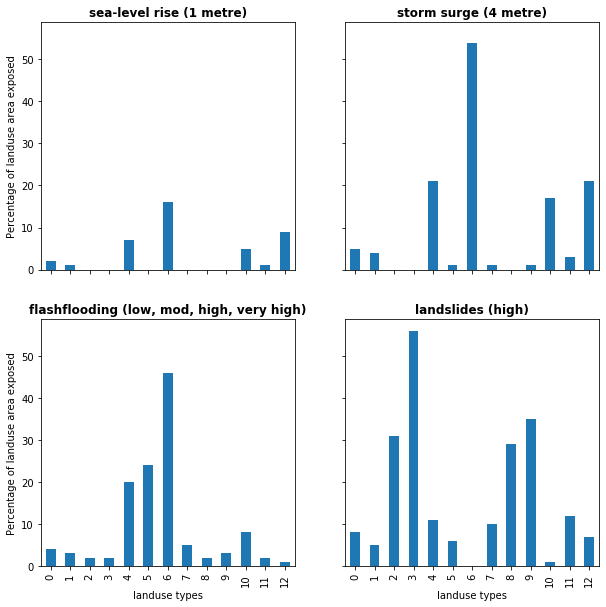

In [186]:
fig, axes = plt.subplots(figsize=(10,10),nrows=2, ncols=2,sharex=True,sharey=True)

plot_to_ax(axes[0,0], 'sea-level rise (1 metre)', type_hazard_per['1m_sea-level'])
plot_to_ax(axes[0,1], 'storm surge (4 metre)', type_hazard_per['4m_storm-surge'])
plot_to_ax(axes[1,0], 'flashflooding (low, mod, high, very high)', type_hazard_per['flashflooding'])
plot_to_ax(axes[1,1], 'landslides (high)', type_hazard_per['landslide_susceptibility'])

plt.savefig(plot_landuse_path)
plt.show()

## Plot landuse aggregated 

In [191]:
type_hazard_exp = pd.read_csv(landuse_type_exp_csv_path)

In [192]:
plot_landuse_agg_path = os.path.join(
    data_folder, 'figures', 'fig_landcover_type_agg.svg')


In [127]:
def plot_to_ax(ax, title, hazard):
    ax = hazard.plot(ax=ax,kind='bar',x='type',y='%_exposed', legend = False,color=['red','green','yellow','blue'])
    ax.set_ylim(0,100)
    ax.set_title(title,fontweight = 'bold')
    ax.set_ylabel('Percentage of landuse area exposed')
    ax.tick_params(axis='x', rotation = 90)
    ax.set_xlabel('landuse types')

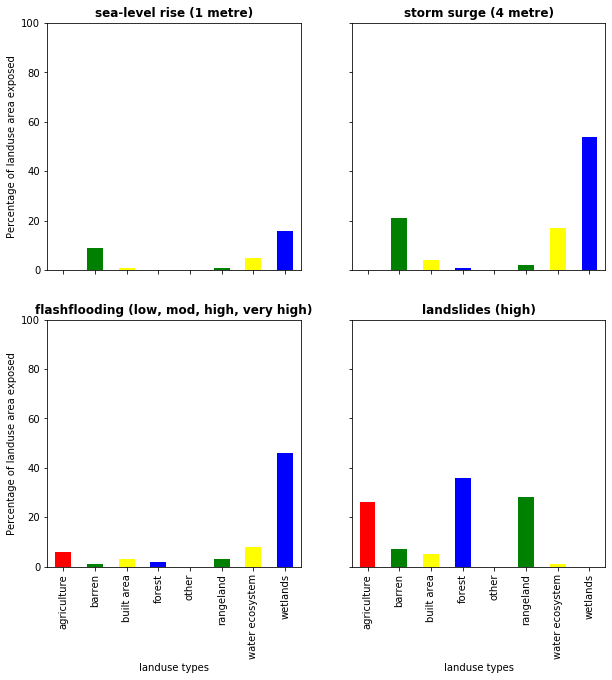

In [128]:
fig, axes = plt.subplots(figsize=(10,10),nrows=2, ncols=2,sharex=True,sharey=True)

plot_to_ax(axes[0,0], 'sea-level rise (1 metre)', type_hazard_per_agg['1m_sea-level'])
plot_to_ax(axes[0,1], 'storm surge (4 metre)', type_hazard_per_agg['4m_storm-surge'])
plot_to_ax(axes[1,0], 'flashflooding (low, mod, high, very high)', type_hazard_per_agg['flashflooding'])
plot_to_ax(axes[1,1], 'landslides (high)', type_hazard_per_agg['landslide_susceptibility'])

plt.savefig(plot_landuse_agg_path)
plt.show()